In [1]:
!pip install numpy pandas tensorflow scikit-learn matplotlib seaborn

Epoch 1/500


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


203/203 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.4037 - loss: 1.3679 - val_accuracy: 0.5166 - val_loss: 1.0174 - learning_rate: 5.0000e-04
Epoch 2/500
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4674 - loss: 1.1201 - val_accuracy: 0.5327 - val_loss: 0.9812 - learning_rate: 5.0000e-04
Epoch 3/500
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4894 - loss: 1.0448 - val_accuracy: 0.5321 - val_loss: 0.9674 - learning_rate: 5.0000e-04
Epoch 4/500
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5064 - loss: 1.0144 - val_accuracy: 0.5469 - val_loss: 0.9390 - learning_rate: 5.0000e-04
Epoch 5/500
203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5279 - loss: 0.9797 - val_accuracy: 0.5592 - val_loss: 0.9226 - learning_rate: 5.0000e-04
Epoch 6/500
203/203 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5339 - loss: 0.9621 - val_accuracy: 0.5610 - val_loss: 0.9096 - learning_rate: 5.0000e-04
Epoch 7/500
203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.545

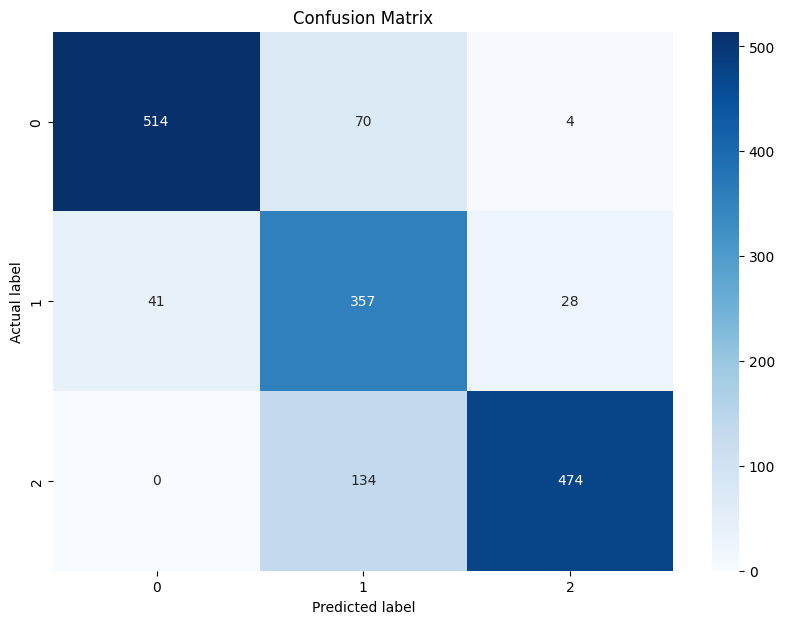

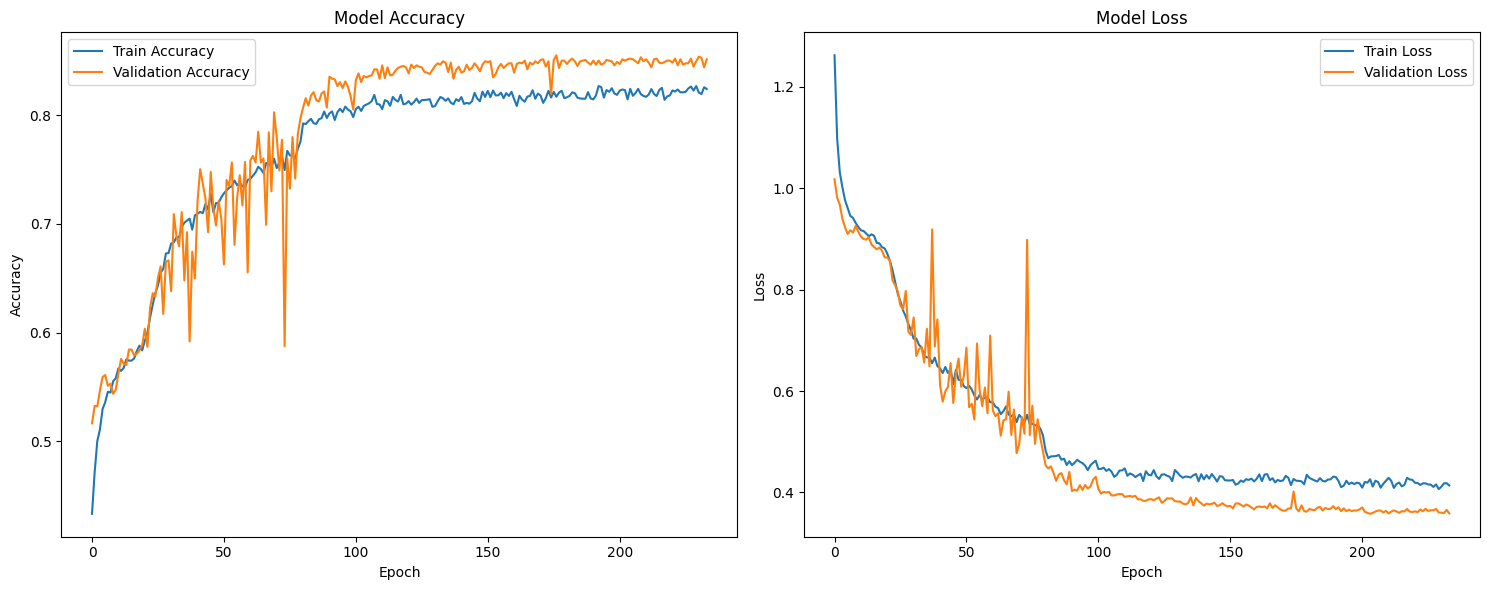

In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report, matthews_corrcoef
import matplotlib.pyplot as plt
import seaborn as sns

# Load the pre-scaled data
X_train = pd.read_pickle('/content/x_train_EURUSD_price.pkl')
y_train = pd.read_pickle('/content/y_train_EURUSD_price.pkl')
X_valid = pd.read_pickle('/content/x_valid_EURUSD_price.pkl')
y_valid = pd.read_pickle('/content/y_valid_EURUSD_price.pkl')
X_test = pd.read_pickle('/content/x_test_EURUSD_price.pkl')
y_test = pd.read_pickle('/content/y_test_EURUSD_price.pkl')

# Define the model with increased capacity
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.4),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(3, activation='softmax')  # Assuming 3 classes for prediction
])

# Compile the model with a lower initial learning rate
model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.00001)

# Train the model for more epochs
history = model.fit(X_train, y_train,
                    validation_data=(X_valid, y_valid),
                    epochs=500,  # Increased number of epochs
                    batch_size=64,  # Slightly larger batch size
                    callbacks=[early_stopping, reduce_lr])

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy}")

# Make predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Print classification report
print(classification_report(y_test, y_pred_classes))

# Calculate Matthews Correlation Coefficient
mcc = matthews_corrcoef(y_test, y_pred_classes)
print(f"Matthews Correlation Coefficient: {mcc}")

# Function for calculating directional accuracy
def directional_accuracy(actuals, forecasts):
    return np.mean((np.sign(actuals[1:] - actuals[:-1]) == np.sign(forecasts[1:] - forecasts[:-1])).astype(int))

# Calculate Directional Accuracy
dir_acc = directional_accuracy(y_test.to_numpy(), y_pred_classes)
print(f"Directional Accuracy: {dir_acc}")

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

# Plot training history
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()